In [1]:
%load_ext autoreload
%autoreload 2

# Genetic Algorithm approach for solving the problem of Project 2.

## Genetic Algorithm proposal:

- **Genetic Algorithm** is a search heuristic that is inspired by Charles Darwin’s theory of natural evolution. This algorithm reflects the process of natural selection where the fittest individuals are selected for reproduction in order to produce offspring of the next generation.
- The algorithm starts with a population of solutions (represented by chromosomes) and applies the principle of natural selection to evolve the population of solutions.
    - For our case, chromosomes will represent the variables used in the model.
    - Given the size of the problem, we will first manually select the best 50 variables using the best performing feature selection method.
    - The genetic algorithm will then be used to select the best subset of these 50 variables.
    - We will also choose the model "manually" during the selection of the best 50 variables.
- The genetic algorithm will be implemented as follows:
    - The fitness function will be the profit function.
    - The genetic operators will be mutation and crossover.
    - The selection operator will be the tournament selection.
    - The stopping criterion will be the number of generations or the number of generations without improvement.
    - The initial population will be generated randomly.
    - The mutation probability will be set to 0.1, and the crossover probability will be set to 0.9. 


## Importing the necessary libraries and loading the data from the previous notebook.

In [2]:
%pip install pygad

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pickle
 
with open('selected_features_per_method.pkl', 'rb') as f:
    selected_features = pickle.load(f)

selected_features

{'mrmr': Index([105,  64, 131, 136, 100, 102,  24, 103, 104, 359, 101,  29, 266,  57,
         39, 241, 351, 155, 335, 442],
       dtype='int64'),
 'surf': Index([105, 102, 101, 321, 100, 289, 283, 374, 254, 311, 380, 103, 339, 303,
        315, 211, 462, 338, 208, 200],
       dtype='int64'),
 'forest': Index([100, 101, 102, 103, 104, 105, 403], dtype='int64'),
 'xgb': Index([100, 101, 102, 103, 104, 105], dtype='int64'),
 'common_features': [105, 100, 102, 103, 104, 101],
 'intersection_common_features': [105, 100, 102, 103, 104, 101],
 'all_common_features': [105,
  64,
  131,
  136,
  100,
  102,
  24,
  103,
  104,
  359,
  101,
  29,
  266,
  57,
  39,
  241,
  351,
  155,
  335,
  442,
  321,
  289,
  283,
  374,
  254,
  311,
  380,
  339,
  303,
  315,
  211,
  462,
  338,
  208,
  200,
  403]}

In [4]:
import pandas as pd
import numpy as np
from utils import cleanup_dataset_apply_standard_scaler, generate_feature_interactions_quadratic, train_and_evaluate_model, max_score
from pygad import pygad
from typing import List

In [5]:
X = pd.read_table('./data/x_train.txt', header=None, delimiter=' ')
y = pd.read_table('./data/y_train.txt', header=None)

X_test = pd.read_table('./data/x_test.txt', header=None, delimiter=' ')

X.head()

correlated_features_to_remove = [1, 0, 4, 6, 7, 3, 5, 8, 9, 2] # Taken from the previous notebook
X = X.drop(correlated_features_to_remove, axis=1)
X_test = X_test.drop(correlated_features_to_remove, axis=1)

X = cleanup_dataset_apply_standard_scaler(X)
X_test = cleanup_dataset_apply_standard_scaler(X_test)

## Genetic Algorithm for Random Forest model

In [6]:
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_eval_train, X_eval_test, y_eval_train, y_eval_test = train_test_split(X, y, test_size=0.2, random_state=0)
all_common_features = pd.Index(selected_features['all_common_features'], dtype='int64')

def apply_optimized_forest(
        X: pd.DataFrame,
        y: pd.Series,
        X_test: pd.DataFrame,
        random_state: int = 0
) -> pd.Series:
    """
    Apply the optimized random forest model to the dataset.
    :param X: pd.DataFrame - The training dataset.
    :param y: pd.Series - The target variable.
    :param X_test: pd.DataFrame - The test dataset.
    :param random_state: int - The random state.
    :return: pd.Series - The predictions.
    """
    
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        max_features="sqrt",
        bootstrap=True,
        random_state=random_state,
        n_jobs=-1,
    )

    model.fit(X, y)
    return pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)


def fitness_function_forest(
        ga_instance: pygad.GA,
        solution: List[int],
        solution_idx: int
) -> float:
    solution = list(map(bool, solution))
    
    if not any(solution):
        return 0
    
    score = train_and_evaluate_model(
        model=apply_optimized_forest,
        X_train=X_eval_train,
        y_train=y_eval_train,
        X_test=X_eval_test,
        y_test=y_eval_test,
        selected_features=all_common_features[solution],
        generate_feature_interactions=generate_feature_interactions_quadratic,
        should_penalize_feature_num=True,
        random_state=0
    )

    return score / max_score(threshold_num=np.sum(y_eval_test.values))

In [7]:
import logging

ga_forest = pygad.GA(
    num_generations=500,
    num_parents_mating=10,
    fitness_func=fitness_function_forest,
    sol_per_pop=50,
    gene_type=int,
    gene_space=[0, 1],
    num_genes=len(all_common_features),
    init_range_low=0,
    init_range_high=1,
    mutation_percent_genes=10,
    crossover_probability=0.7,
    mutation_probability=0.3,
    parent_selection_type='tournament',
    keep_parents=2,
    crossover_type='single_point',
    mutation_type='random',
    random_mutation_min_val=0,
    random_mutation_max_val=1,
    random_seed=0,
    save_best_solutions=True,
    logger=logging.getLogger(),
    stop_criteria="reach_0.8",
    parallel_processing=["thread", 4]
)

In [35]:
ga_forest.run()

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


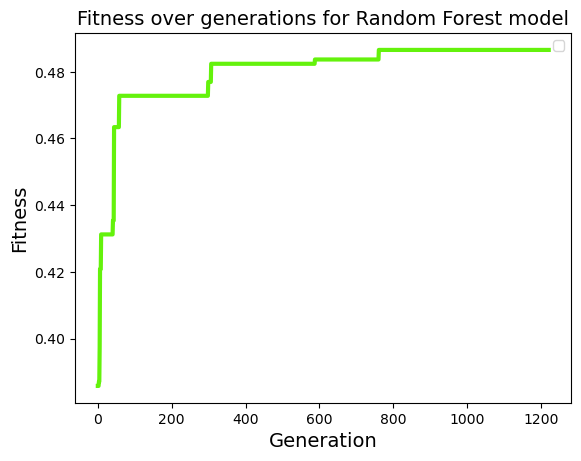

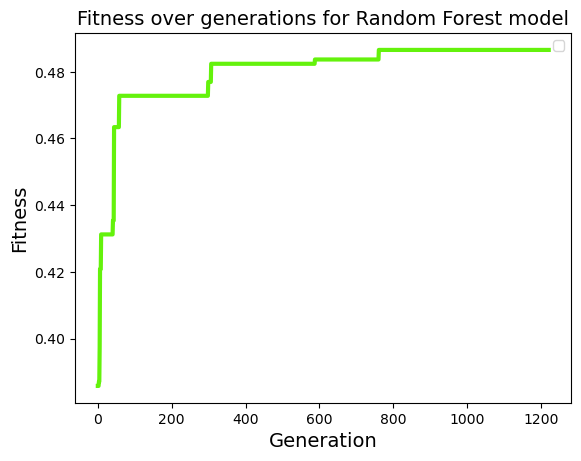

In [37]:
ga_forest.plot_fitness(title='Fitness over generations for Random Forest model')

In [38]:
ga_forest.save('genetic_algorithm_solution_for_forest')

In [11]:
ga_forest = pygad.load('genetic_algorithm_solution_for_forest')

In [39]:
solution, solution_fitness, solution_id = ga_forest.best_solution()

In [40]:
solution = list(map(bool, solution))
all_common_features[solution], solution_fitness

(Index([105, 100, 102, 103, 101, 241, 335, 200], dtype='int64'),
 0.4865696465696466)

## Genetic Algorithm for SVM model

In [14]:
from typing import List
from sklearn.model_selection import train_test_split
from utils import train_and_evaluate_model, max_score
from sklearn.svm import SVC

X_eval_train, X_eval_test, y_eval_train, y_eval_test = train_test_split(X, y, test_size=0.2, random_state=0)
all_common_features = pd.Index(selected_features['all_common_features'], dtype='int64')

def apply_optimized_svm(
        X: pd.DataFrame,
        y: pd.Series,
        X_test: pd.DataFrame,
        random_state: int = 0
) -> pd.Series:
    """
    Apply the optimized SVM model to the dataset.
    :param X: pd.DataFrame - The training dataset.
    :param y: pd.Series - The target variable.
    :param X_test: pd.DataFrame - The test dataset.
    :param random_state: int - The random state.
    :return: pd.Series - The predictions.
    """
    
    model = SVC(
        C=0.1,
        gamma=0.1,
        class_weight='balanced',
        kernel='rbf',
        random_state=random_state,
        probability=True
    )

    model.fit(X, y)
    return pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)


def fitness_function_svm(
        ga_instance: pygad.GA,
        solution: List[int],
        solution_idx: int
) -> float:
    solution = list(map(bool, solution))
    
    if not any(solution):
        return 0
    
    score = train_and_evaluate_model(
        model=apply_optimized_svm,
        X_train=X_eval_train,
        y_train=y_eval_train,
        X_test=X_eval_test,
        y_test=y_eval_test,
        selected_features=all_common_features[solution],
        generate_feature_interactions=generate_feature_interactions_quadratic,
        should_penalize_feature_num=True,
        random_state=0
    )

    return score / max_score(threshold_num=np.sum(y_eval_test.values))

In [15]:
import logging

ga_svm = pygad.GA(
    num_generations=500,
    num_parents_mating=10,
    fitness_func=fitness_function_svm,
    sol_per_pop=50,
    gene_type=int,
    gene_space=[0, 1],
    num_genes=len(all_common_features),
    init_range_low=0,
    init_range_high=1,
    mutation_percent_genes=10,
    crossover_probability=0.9,
    mutation_probability=0.1,
    parent_selection_type='tournament',
    keep_parents=2,
    crossover_type='single_point',
    mutation_type='random',
    random_mutation_min_val=0,
    random_mutation_max_val=1,
    random_seed=0,
    save_best_solutions=True,
    logger=logging.getLogger(),
    stop_criteria="reach_0.8",
    parallel_processing=["thread", 8]
)

In [16]:
ga_svm.run()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


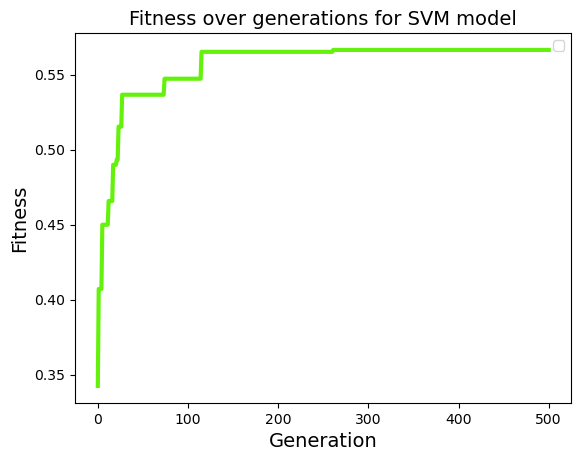

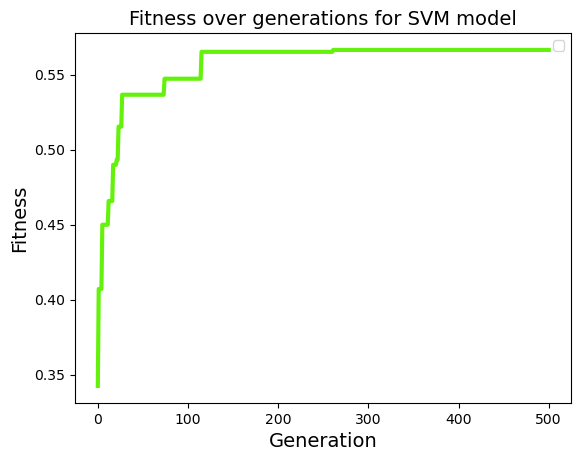

In [17]:
ga_svm.plot_fitness(title='Fitness over generations for SVM model')

In [18]:
ga_svm.save('genetic_algorithm_solution_for_svm')

In [19]:
ga_svm = pygad.load('genetic_algorithm_solution_for_svm')

In [29]:
solution, solution_fitness, solution_id = ga_svm.best_solution()

In [30]:
solution = list(map(bool, solution))
all_common_features[solution], solution_fitness

(Index([105, 100, 102, 101], dtype='int64'), 0.5665696465696465)

## Genetic Algorithm for KNN model

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from typing import List
from sklearn.model_selection import train_test_split

X_eval_train, X_eval_test, y_eval_train, y_eval_test = train_test_split(X, y, test_size=0.2, random_state=0)
all_common_features = pd.Index(selected_features['all_common_features'], dtype='int64')

def apply_optimized_knn(
        X: pd.DataFrame,
        y: pd.Series,
        X_test: pd.DataFrame,
        random_state: int = 0
) -> pd.Series:
    """
    Apply the optimized KNN model to the dataset.
    :param X: pd.DataFrame - The training dataset.
    :param y: pd.Series - The target variable.
    :param X_test: pd.DataFrame - The test dataset.
    :param random_state: int - The random state.
    :return: pd.Series - The predictions.
    """
    
    model = KNeighborsClassifier(
        n_neighbors=250,
        weights='distance',
        algorithm='auto',
        p=2,
        n_jobs=-1
    )

    model.fit(X, y)
    return pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)


def fitness_function_knn(
        ga_instance: pygad.GA,
        solution: List[int],
        solution_idx: int
) -> float:
    solution = list(map(bool, solution))
    
    if not any(solution):
        return 0
    
    score = train_and_evaluate_model(
        model=apply_optimized_knn,
        X_train=X_eval_train,
        y_train=y_eval_train,
        X_test=X_eval_test,
        y_test=y_eval_test,
        selected_features=all_common_features[solution],
        generate_feature_interactions=generate_feature_interactions_quadratic,
        should_penalize_feature_num=True,
        random_state=0
    )

    return score / max_score(threshold_num=np.sum(y_eval_test.values))

In [42]:
import logging

ga_knn = pygad.GA(
    num_generations=1000,
    num_parents_mating=10,
    fitness_func=fitness_function_knn,
    sol_per_pop=50,
    gene_type=int,
    gene_space=[0, 1],
    num_genes=len(all_common_features),
    init_range_low=0,
    init_range_high=1,
    mutation_percent_genes=10,
    crossover_probability=0.9,
    mutation_probability=0.1,
    parent_selection_type='tournament',
    keep_parents=2,
    crossover_type='single_point',
    mutation_type='random',
    random_mutation_min_val=0,
    random_mutation_max_val=1,
    random_seed=0,
    save_best_solutions=True,
    logger=logging.getLogger(),
    stop_criteria="reach_0.8",
    parallel_processing=["thread", 8]
)

In [47]:
ga_knn.run()

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


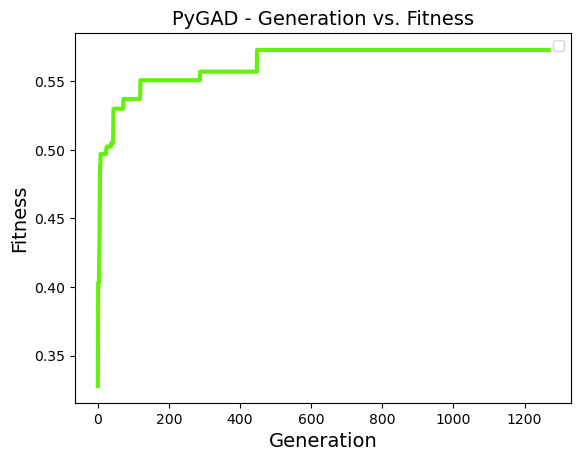

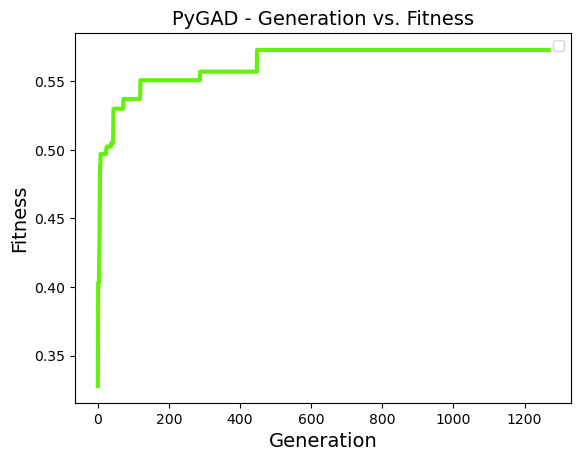

In [48]:
ga_knn.plot_fitness()

In [49]:
ga_knn.save('genetic_algorithm_solution_for_knn')

In [ ]:
ga_knn = pygad.load('genetic_algorithm_solution_for_knn')

In [50]:
solution, solution_fitness, solution_id = ga_knn.best_solution()

In [52]:
solution = list(map(bool, solution))
all_common_features[solution], solution_fitness

(Index([105, 100, 102, 104], dtype='int64'), 0.5728066528066528)

## Genetic Algorithm for LightGBM model

In [69]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

X_eval_train, X_eval_test, y_eval_train, y_eval_test = train_test_split(X, y, test_size=0.2, random_state=0)
all_common_features = pd.Index(selected_features['all_common_features'], dtype='int64')

def apply_optimized_lightgbm(
        X: pd.DataFrame,
        y: pd.Series,
        X_test: pd.DataFrame,
        random_state: int = 0
) -> pd.Series:
    """
    Apply the optimized LightGBM model to the dataset.
    :param X: pd.DataFrame - The training dataset.
    :param y: pd.Series - The target variable.
    :param X_test: pd.DataFrame - The test dataset.
    :param random_state: int - The random state.
    :return: pd.Series - The predictions.
    """

    model = LGBMClassifier(
        n_estimators=50,
        boosting_type='dart',
        objective='binary',
        learning_rate=0.1,
        num_leaves=31,
        random_state=random_state,
        n_jobs=1,
        force_col_wise=True,
        verbose=-1
    )

    model.fit(X, y)
    return pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

def fitness_function_lightgbm(
        ga_instance: pygad.GA,
        solution: List[int],
        solution_idx: int
) -> float:
    solution = list(map(bool, solution))
    
    if not any(solution):
        return 0
    
    score = train_and_evaluate_model(
        model=apply_optimized_lightgbm,
        X_train=X_eval_train,
        y_train=y_eval_train,
        X_test=X_eval_test,
        y_test=y_eval_test,
        selected_features=all_common_features[solution],
        generate_feature_interactions=generate_feature_interactions_quadratic,
        should_penalize_feature_num=True,
        random_state=0
    )

    return score / max_score(threshold_num=np.sum(y_eval_test.values))

In [54]:
import logging

ga_lightgbm = pygad.GA(
    num_generations=500,
    num_parents_mating=10,
    fitness_func=fitness_function_lightgbm,
    sol_per_pop=50,
    gene_type=int,
    gene_space=[0, 1],
    num_genes=len(all_common_features),
    init_range_low=0,
    init_range_high=1,
    mutation_percent_genes=10,
    crossover_probability=0.9,
    mutation_probability=0.1,
    parent_selection_type='tournament',
    keep_parents=2,
    crossover_type='single_point',
    mutation_type='random',
    random_mutation_min_val=0,
    random_mutation_max_val=1,
    random_seed=0,
    save_best_solutions=True,
    logger=logging.getLogger(),
    stop_criteria="reach_0.8",
    parallel_processing=["thread", 8]
)

In [74]:
ga_lightgbm.fitness_func = fitness_function_lightgbm
ga_lightgbm.run()

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


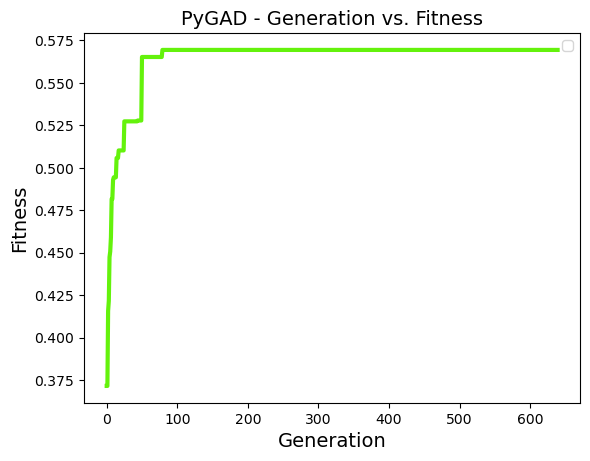

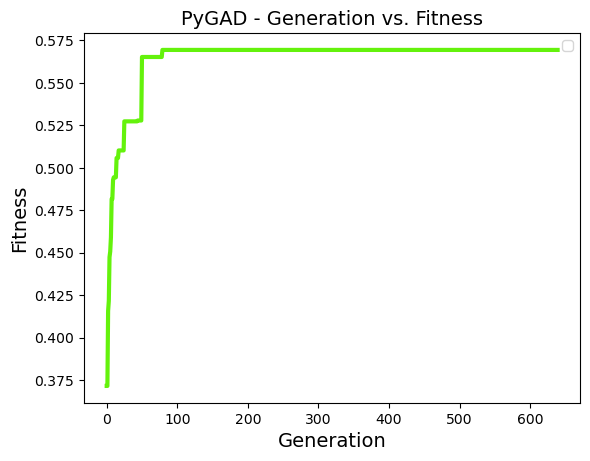

In [76]:
ga_lightgbm.plot_fitness()

In [77]:
ga_lightgbm.save('genetic_algorithm_solution_for_lightgbm')

In [ ]:
ga_lightgbm = pygad.load('genetic_algorithm_solution_for_lightgbm')

In [78]:
solution, solution_fitness, solution_id = ga_lightgbm.best_solution()

In [79]:
solution = list(map(bool, solution))
all_common_features[solution], solution_fitness

(Index([105, 100, 102, 104, 101], dtype='int64'), 0.5694386694386694)